In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
DATA_DIR = '../input/data/'
image_size = 256
batch_size = 32

In [5]:
df = pd.read_csv(f'{DATA_DIR}Data_Entry_2017.csv')

In [6]:
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', '*', '*.png'))}

In [7]:
df['path'] = df['Image Index'].map(data_image_paths.get)

In [8]:
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

In [9]:
labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x) > 0]

In [10]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [11]:
for label in labels:
    if len(label) > 1:
        df[label] = df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0.0)

In [12]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
labels = [label for label in labels if df[label].sum() > 1000]
labels

In [13]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=2018, stratify=df['Finding Labels'].map(lambda x: x[:4]))

In [14]:
train_df['labels'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
valid_df['labels'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
core_idg = ImageDataGenerator(rescale=1 / 255,
                                  samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  height_shift_range=0.05,
                                  width_shift_range=0.1,
                                  rotation_range=5,
                                  shear_range=0.1,
                                  fill_mode='reflect',
                                  zoom_range=0.15)

train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                                       directory=None,
                                                       x_col='path',
                                                       y_col='labels',
                                                       class_mode='categorical',
                                                       batch_size=1024,
                                                       classes=labels,
                                                       target_size=(image_size, image_size)))

Found 41407 validated image filenames belonging to 14 classes.
Found 10352 validated image filenames belonging to 14 classes.
Found 10352 validated image filenames belonging to 14 classes.


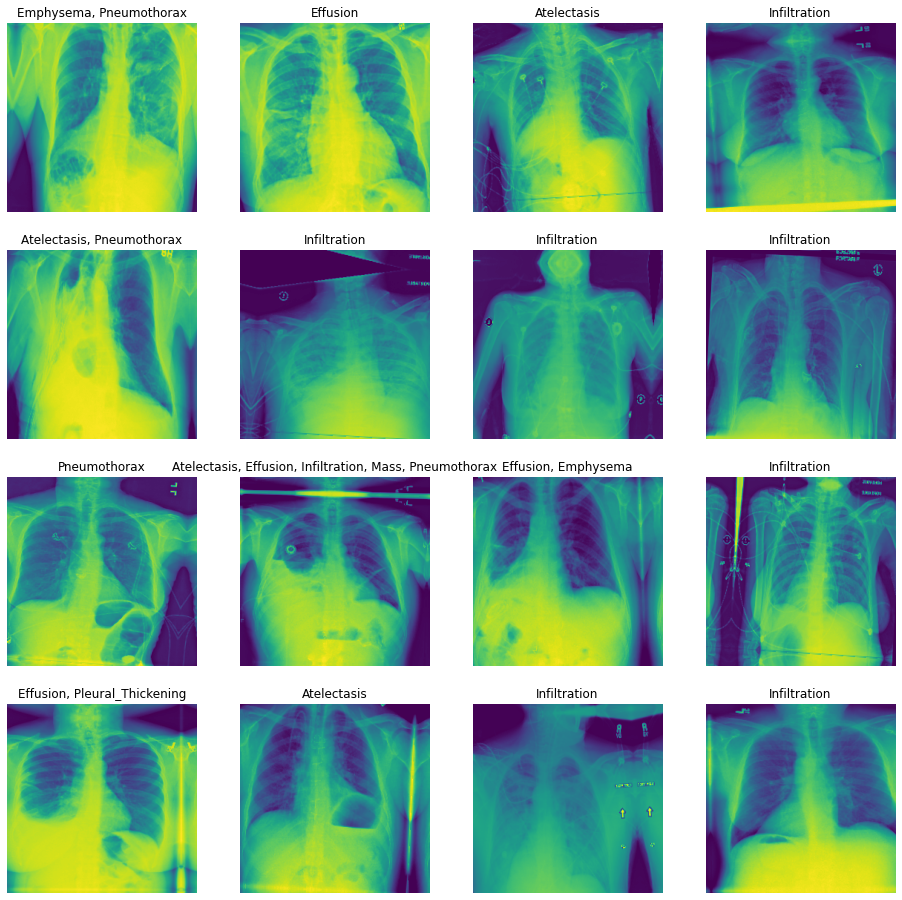

In [16]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0])
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')


In [17]:
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
#from generator import DataGenerator
import keras

In [18]:
# DenseNet model
from keras.applications.densenet import DenseNet121, preprocess_input
img_in = Input(t_x.shape[1:])              #input of model 
DenseNet_model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= t_x.shape[1:],
                pooling ='avg') 

x = DenseNet_model.output  
predictions = Dense(len(labels), activation="softmax", name="predictions")(x)    # fuly connected layer for predict class 
DenseNet_model = Model(inputs=img_in, outputs=predictions)

29089792/29084464 [==============================] - 0s 0us/step


In [19]:
#Learning rate & loss specified in Base paper
optimizer = Adam(lr=0.001)
DenseNet_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy])

In [21]:
# set up a checkpoint for model training
# https://keras.io/callbacks/
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights.best.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only = True)
callbacks_list = [checkpointer]

In [22]:
#Epochs from Base Paper && Best value of Steps per epoch is other papers
history = DenseNet_model.fit(train_gen, 
                                  steps_per_epoch=128,
                                  validation_data = (test_X, test_Y), callbacks = callbacks_list,
                                  epochs = 100)

Epoch 1/100
128/128 [==============================] - 181s 1s/step - loss: 0.3340 - binary_accuracy: 0.8882 - val_loss: 0.4363 - val_binary_accuracy: 0.8723

Epoch 00001: val_loss improved from inf to 0.43634, saving model to weights.best.01-0.44.hdf5
Epoch 2/100
128/128 [==============================] - 165s 1s/step - loss: 0.2949 - binary_accuracy: 0.8898 - val_loss: 0.3104 - val_binary_accuracy: 0.8906

Epoch 00002: val_loss improved from 0.43634 to 0.31044, saving model to weights.best.02-0.31.hdf5
Epoch 3/100
128/128 [==============================] - 159s 1s/step - loss: 0.2863 - binary_accuracy: 0.8927 - val_loss: 0.8318 - val_binary_accuracy: 0.8737

Epoch 00003: val_loss did not improve from 0.31044
Epoch 4/100
128/128 [==============================] - 158s 1s/step - loss: 0.2836 - binary_accuracy: 0.8923 - val_loss: 0.3155 - val_binary_accuracy: 0.8896

Epoch 00004: val_loss did not improve from 0.31044
Epoch 5/100
128/128 [==============================] - 151s 1s/step - 

In [23]:
DenseNet_model.save('Densenet_model.h5')

In [24]:
from keras.models import load_model
densemodel = tf.keras.models.load_model('Densenet_model.h5')

In [ ]:
disease_name = ["Atelectasis","Cardiomegaly","Effusion","Infiltration","Mass","Nodule","Pneumonia","Pneumothorax","Consolidation","Edema","Emphysema","Fibrosis","Pleural Thickening","Hernia"] 

In [26]:
test_X.shape
sample_image = test_X[1]
sample_image = sample_image.reshape((1, 256,256,3))
x = densemodel.predict(sample_image)
def disease(arr):
    print(arr.size)
    for i in range(arr.size):
        print("Disease:",labels[i],"Probability:",arr[i])
    
disease(x[0]) 

14
Disease: Atelectasis Probability: 0.28886876
Disease: Cardiomegaly Probability: 0.0012926749
Disease: Consolidation Probability: 0.028492892
Disease: Edema Probability: 0.0049912734
Disease: Effusion Probability: 0.08251578
Disease: Emphysema Probability: 0.03464187
Disease: Fibrosis Probability: 0.14982666
Disease: Hernia Probability: 0.0003251725
Disease: Infiltration Probability: 0.13114427
Disease: Mass Probability: 0.08735793
Disease: Nodule Probability: 0.04363392
Disease: Pleural_Thickening Probability: 0.049085036
Disease: Pneumonia Probability: 0.015269009
Disease: Pneumothorax Probability: 0.08255471


In [28]:
test_X.shape
sample_image = test_X[3]
sample_image = sample_image.reshape((1, 256,256,3))
x = densemodel.predict(sample_image)
def disease(arr):
    for i in range(arr.size):
        print("Disease:",labels[i],"Probability:",int(arr[i]*100),"%")
    
disease(x[0]) 

Disease: Atelectasis Probability: 0 %
Disease: Cardiomegaly Probability: 0 %
Disease: Consolidation Probability: 0 %
Disease: Edema Probability: 0 %
Disease: Effusion Probability: 21 %
Disease: Emphysema Probability: 0 %
Disease: Fibrosis Probability: 0 %
Disease: Hernia Probability: 0 %
Disease: Infiltration Probability: 4 %
Disease: Mass Probability: 52 %
Disease: Nodule Probability: 17 %
Disease: Pleural_Thickening Probability: 0 %
Disease: Pneumonia Probability: 0 %
Disease: Pneumothorax Probability: 1 %


# Voting Code

In [32]:
import cv2

In [35]:
def DensepredictClass(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img /255
    img = cv2.resize(img, (256, 256))
    img = img.reshape((1,256,256,3))
    return DenseNet_model.predict(img)

In [30]:
def classnames(arr):
    print(arr.size)
    for i in range(arr.size):
        print("Disease:", labels[i], " Probability:",arr[i]*100)

In [46]:
#Prediction
path = "../input/data/images_001/images/00000004_000.png"
#Prediction
x = DensepredictClass(path)
print("\nDenseNet")
classnames(x[0])


DenseNet
14
Disease: Atelectasis  Probability: 7.045650482177734
Disease: Cardiomegaly  Probability: 2.040725387632847
Disease: Consolidation  Probability: 1.6387997195124626
Disease: Edema  Probability: 2.758942171931267
Disease: Effusion  Probability: 1.924029365181923
Disease: Emphysema  Probability: 1.0532560758292675
Disease: Fibrosis  Probability: 1.1092192493379116
Disease: Hernia  Probability: 0.17085233703255653
Disease: Infiltration  Probability: 4.924236238002777
Disease: Mass  Probability: 39.94576632976532
Disease: Nodule  Probability: 20.641377568244934
Disease: Pleural_Thickening  Probability: 1.8113931640982628
Disease: Pneumonia  Probability: 0.10898445034399629
Disease: Pneumothorax  Probability: 14.826767146587372
